In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from tqdm.notebook import tqdm, trange
import torch
import autograd.numpy as np
import autograd.scipy.stats as stats
import scipy.optimize as optimize
from autograd.scipy.linalg import logm
from autograd import grad, jacobian, hessian
import numpy
import scipy
import pandas as pd
import ipywidgets as widgets

In [2]:
def decode_q_params(encoded_q):
        shape = len(encoded_q)
        mean_shape = 3
        A_shape = (int(np.sqrt(shape - mean_shape)), int(np.sqrt(shape - mean_shape)))
        mean = encoded_q[0:mean_shape]
        A = encoded_q[mean_shape:shape].reshape(A_shape)
        return mean, A
def encode_q_params(q_params):
    mean, A = q_params
    return np.array(list(mean) + list(A.flatten()))

def decode_d(encoded_d, dim=2):
    return encoded_d.reshape(int(len(encoded_d)/dim), dim)
def encode_d(d):
    return d.flatten()

In [181]:
def optimizer(x0, gradient, callback=lambda x, g: True, rate=0.5, iters=1e1, label=None, leave=True, thres=5):
    x = x0
    running_average = []
    for i in tqdm(range(int(iters)), desc=label, leave=leave):
        r = rate/(rate+i*1e-2)
        g = gradient(x)
        running_average.append(g)
        x = -g * r + x
        if i % 1 == 0:
            if not callback(x, g):
                break
    return x

In [4]:
def log_posterior(theta_i, q_params):
    mean, A = q_params
    return scipy.stats.multivariate_normal.logpdf(theta_i, mean=mean, cov=A @ A.T)

In [182]:
def stable_multivariate_gaussian_logpdf(x, mu, cov):
    n = len(x)
    x_mu = x - mu
    try:
        _, log_det = np.linalg.slogdet(cov)
        cov_inv = np.linalg.inv(cov)
        log_prob = -0.5 * (n * np.log(2 * np.pi) + log_det + np.dot(x_mu, np.dot(cov_inv, x_mu)))
    except np.linalg.LinAlgError:
        cov_modified = cov + np.eye(n) * 1e-8
        _, log_det = np.linalg.slogdet(cov_modified)
        cov_inv = np.linalg.inv(cov_modified)
        log_prob = -0.5 * (n * np.log(2 * np.pi) + log_det + np.dot(x_mu, np.dot(cov_inv, x_mu)))
    return log_prob
def elbo(q_params, d, y_i, shape=3):
    #print('y_i 2', str(y_i))
    def log_likelihood(y, theta, d):
        #print(y, theta, d)
        likelihood_cov = np.mean(np.square(y - theta.T @ d.T)) * np.eye(len(d))
        likelihood_mean = d @ theta
        return stable_multivariate_gaussian_logpdf(y, likelihood_mean, likelihood_cov)
    def KLD(mean_q, A_q, mean_p, A_p):
        sigma_q = (A_q @ A_q.T)
        sigma_p = (A_p @ A_p.T)
        bar_sigma_q = np.linalg.norm(sigma_q)
        bar_sigma_p = np.linalg.norm(sigma_p)
        k = len(mean_q)
        return 0.5 * (np.trace(np.linalg.inv(sigma_p) @ sigma_q) + (mean_p - mean_q).T @ np.linalg.inv(sigma_p) @ (mean_p - mean_q) - k + np.log(bar_sigma_p/bar_sigma_q))
    mean, A = q_params
    values = []
    for _ in range(30):
        sample = np.random.multivariate_normal(np.zeros(shape), np.eye(shape))
        theta = mean + A @ sample
        lik = log_likelihood(y_i, theta, d)
        values.append(lik)
    return 1/(len(values))*np.sum(values) - KLD(mean, A, mean_prior, A_prior)

In [201]:
def log_posterior_grad(theta_i, y_i, d, q_params):
    def training_hessian_inner(q_params):
        return elbo(decode_q_params(q_params), d, y_i)
    def training_mixed_partials_inner(encoded_q):
        #print("Encoded d %s" % str(encode_d(d)))
        #print("inner result: %s" % str(encode_d(grad(lambda d: elbo(decode_q_params(encoded_q), d, y_i))(d))))
        return encode_d(grad(lambda d: elbo(decode_q_params(encoded_q), d, y_i))(d))
    def inner_grad_q(encoded_q_params):
        mean, A = decode_q_params(encoded_q_params)
        return stable_multivariate_gaussian_logpdf(theta_i, mean, A @ A.T)
    training_hessian = hessian(training_hessian_inner)
    training_mixed_partials = jacobian(training_mixed_partials_inner)
    encoded_q = encode_q_params(q_params)
    latest_hessian = training_hessian(encoded_q) # 12 x 12
    grad_log_q = grad(inner_grad_q)(encoded_q).reshape(1, len(encoded_q)) # 1 x 12
    for i in range(20):
        if np.linalg.det(latest_hessian) != 0:
            evaluated_partials = training_mixed_partials(encoded_q)
            return (grad_log_q @ (- np.linalg.inv(latest_hessian) @ evaluated_partials.T))[0]
        latest_hessian = latest_hessian + 1e-8 * np.eye(latest_hessian.shape)
    raise ValueError("Was not able to invert hessian")

In [204]:
# Get returns mean, A for log q to approximate log_posterior
def optimal_q(d, y_i):
    thetas = []
    def objective_f(encoded_q):
        q_params = decode_q_params(encoded_q)
        return elbo(q_params, d, y_i)
    def callback(qi, g):
        mean, A = decode_q_params(qi)
        #print("Elbo: %f.05,\t  grad: %f.05" % (objective_f(qi), np.linalg.norm(g)))
        return True
        #print("\t New ELBO iteration. mean=%s, A=%s" % (str(mean), str(A)))
    results = optimizer(
        encode_q_params(
            (mean_prior, A_prior)
        ), 
        grad(objective_f), 
        callback=callback, 
        rate=10, 
        label="Optimizing for q", 
        leave=False, 
        iters=20, 
        thres=0.01
    )
    return decode_q_params(results)

In [185]:
noise = 0.2
def MI_grad(d_):
    d = np.concatenate((d_, np.array([np.ones(d_.shape[0])]).T), axis=1)
    size = d.shape[0]
    N = 10
    theta_samples = np.random.multivariate_normal(mean_prior, A_prior, size=N)
    sample_results = []
    elbos = []
    optimal_qs = []
    for i in tqdm(range(N), desc="Computing optimal q samples", leave=False):
        theta_i = theta_samples[i]
        z_i = np.random.multivariate_normal(np.zeros(size), noise * np.eye(size))
        y_i = theta_i @ d.T + z_i
        q_params = optimal_q(d, y_i)
        #print("Got optimal q")
        optimal_qs.append(q_params)
        #print("Computing log posterior...")
        result = log_posterior_grad(theta_i, y_i, d, q_params) * (log_posterior(theta_i, q_params) + 1)
        #print("Got result!")
        sample_results.append(result)
        elbos.append(elbo(q_params, d, y_i))
    optimal_params.append(optimal_qs)
    #print("ELBO: ", str(np.mean(elbos)))
    #print("MI_grad: ", str(np.mean(sample_results)))
    #print(sample_results)
    #print("sample results, mean 0", str(np.mean(np.array(sample_results), axis=0).shape))
    #print(encode_d(decode_d(np.mean(np.array(sample_results), axis=0), dim=3)[:, 0:2]))
    return decode_d(np.mean(np.array(sample_results), axis=0), dim=3)[:, 0:2]


In [186]:
#np.concatenate((np.random.rand(100, 2) * 10, np.array([np.ones(100)]).T), axis=1)
np.mean(np.array([[1, 2], [2,3]]))

2.0

In [205]:
#d0 = np.array([[1,1], [2,2], [3,9]])
d0 = np.random.rand(10,2)*20
A_prior = np.array([[5, -2, 1],
              [-2, 4, -1],
              [1, -1, 3]]) * 10
mean_prior = np.array([2, 5, 6])
optimal_params = []
dis = []
def callback(di, g):
    if len(dis) > 0:
        print("New MI iteration. delta-di=%s. g=%s" % (np.linalg.norm(dis[-1] - di), np.linalg.norm(g)))
    dis.append(di)
    return True
optimizer(d0, MI_grad, callback=callback, label="Optimizing for d", rate=10, iters=50)

Optimizing for d:   0%|          | 0/50 [00:00<?, ?it/s]

Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=9.583475617216125. g=9.593059092833341


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=4.274315372756524. g=4.282864003502036


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=6.0791351942587015. g=6.097372599841477


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=0.6087764970940887. g=0.6112116030824652


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=5.354414401011198. g=5.381186473016254


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=1.2006182423255833. g=1.2078219517795363


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=3.3165643009459322. g=3.3397802510525536


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=0.7056753772241267. g=0.7113207802419196


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=2.1364759080430407. g=2.155704191215429


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=11.338747213695637. g=11.452134685832593


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=2.564137273505688. g=2.5923427835142516


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=0.753779115439728. g=0.7628244648250042


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=0.38577726467572016. g=0.3907923691165049


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=1.8003670007249597. g=1.8255721387351092


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=2.9682024633804485. g=3.012725500331155


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=1.6585234572754328. g=1.6850598325918398


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=0.2563552802792132. g=0.2607133200439599


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=1.1050875090813645. g=1.1249790842448282


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=0.38609228814944396. g=0.39342804162428363


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=0.7240890194130922. g=0.7385707998013538


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=2.2180681730381195. g=2.2646476046719206


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=0.46763813288298933. g=0.4779261718064152


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=11.303896406836559. g=11.5638860241938


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=0.5567059171960308. g=0.5700668592087352


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=1.2267788458353373. g=1.25744831698122


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=0.9851587429116908. g=1.0107728702273955


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=11.932185001991078. g=12.254353997044836


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=1.005095266834252. g=1.0332379343056115


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=0.799716709335175. g=0.8229084939058955


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=2.017615823086939. g=2.078144297779546


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=30.530921001449332. g=31.477379552494263


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=3.1867307703087975. g=3.2887061549586782


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=3.9913491070272595. g=4.1230636275591594


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=2.928433248155494. g=3.0279999785927805


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=0.47311496032186384. g=0.48967398393312966


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=25.756144489091938. g=26.683365690699247


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=0.5293969612577146. g=0.5489846488242512


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=0.7530377983412155. g=0.7816532346781824


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=1.3904709282101801. g=1.4446992944103774


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=2.787600230824292. g=2.899104240057264


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=0.5283175065276202. g=0.5499785242952533


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=1.0579794262129152. g=1.1024145621138575


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=2.9008812512514495. g=3.0256191450552605


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=1.6564029703496082. g=1.729284701044991


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=0.8287736299754436. g=0.866068443324339


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=2.8624923685403405. g=2.9941670174931967


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=5.384810767600229. g=5.63789687367744


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=1.0896484221710867. g=1.1419515464352992


Computing optimal q samples:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/20 [00:00<?, ?it/s]

New MI iteration. delta-di=6.802173221675651. g=7.135479709537758


array([[15.34329719,  9.48338798],
       [-5.9590428 ,  6.8111329 ],
       [38.86523948, 10.81807205],
       [29.74021848, 11.35627073],
       [-6.93431977,  6.318022  ],
       [ 8.46882268,  7.99024014],
       [ 8.5568537 ,  7.26380782],
       [10.71361973,  9.46253308],
       [18.48951217,  8.44269802],
       [28.50655129,  8.25251871]])

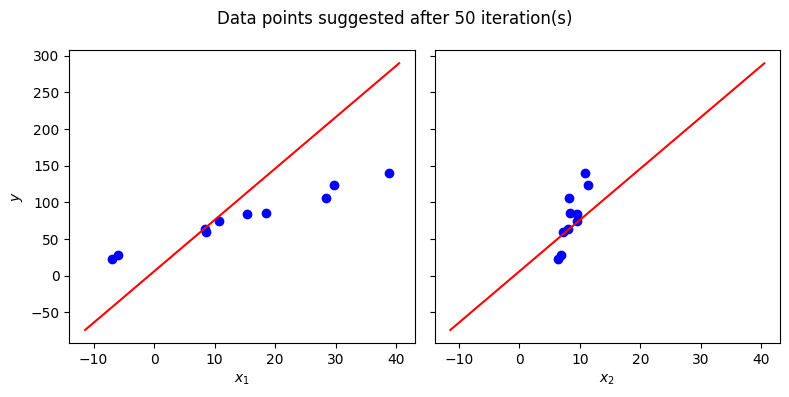

In [211]:
plots = []
#ind = 0
i = 49
di, q_params = list(zip(dis, optimal_params))[i]
mean = np.mean([mean for mean, A in q_params], axis=0)
xs = np.array([np.linspace(np.min(dis), np.max(dis), 200), np.linspace(np.min(dis), np.max(dis), 200), np.ones(200)]).T
ys = mean_prior @ xs.T
diy = mean @ np.array([di[:, 0], di[:, 1], np.ones(len(di))])

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(8, 4))
axes[0].scatter(di[:, 0],  diy, c='blue')
axes[0].plot(xs[:,0], ys, c='red')
axes[0].set_xlabel("$x_%s$" % (1))
axes[0].set_ylabel("$y$")

axes[1].scatter(di[:, 1],  diy, c='blue')
axes[1].plot(xs[:,1], ys, c='red')
axes[1].set_xlabel("$x_%s$" % (2))
plt.suptitle("Data points suggested after %s iteration(s)" % (i + 1))
plt.tight_layout()
plt.show()
#plots = [plt.plot(x, y) for y in range(10)]

Text(0.5, 1.0, '')

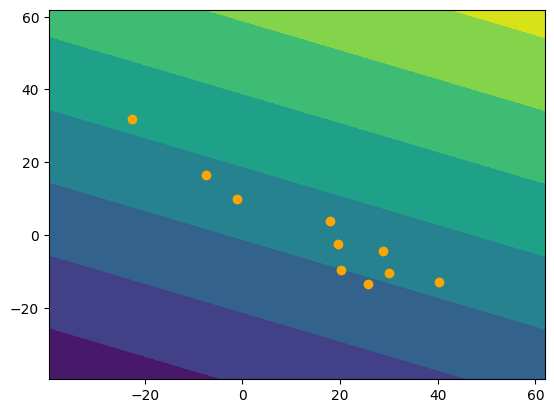

In [200]:
i = 1
di, q_params = list(zip(dis, optimal_params))[i]
diy = mean @ np.array([di[:, 0], di[:, 1], np.ones(len(di))])

# Contour
x1 = np.linspace(np.min(dis) - 10, np.max(dis) + 10, 500)
x2 = np.linspace(np.min(dis) - 10, np.max(dis) + 10, 500)
X1, X2 = np.meshgrid(x1, x2)

Z = mean[0] * X1 + mean[1] * X2 + mean[2] * np.ones(500)
plt.contourf(X1, X2, Z)

plt.scatter(di[:, 0], di[:, 1], c='orange')
plt.title("")

In [18]:
cache_1 = (dis, optimal_params)

# Example in practice: Red Wine Alcohol Level
To test this in practice, we are first train a linear model to predict the alcohol of a given portugese red wine.
Then we are going to predict 10 hypothetical red wines that we wish to produce that can increase our confidence in this model.

Dataset is from Kaggle: https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009?resource=download

In [40]:
from sklearn import linear_model
from sklearn.decomposition import PCA

In [18]:
data_set = pd.read_csv("winequality-red.csv")
data_set

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [56]:
X = data_set[["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates"]]
y = data_set["quality"]

In [68]:
clf = linear_model.BayesianRidge()
clf.fit(X, y)
clf.get_params()

{'alpha_1': 1e-06,
 'alpha_2': 1e-06,
 'alpha_init': None,
 'compute_score': False,
 'copy_X': True,
 'fit_intercept': True,
 'lambda_1': 1e-06,
 'lambda_2': 1e-06,
 'lambda_init': None,
 'n_iter': 300,
 'tol': 0.001,
 'verbose': False}

In [47]:
pca = PCA(n_components=10)
pca.fit(X)

PCA(n_components=10)

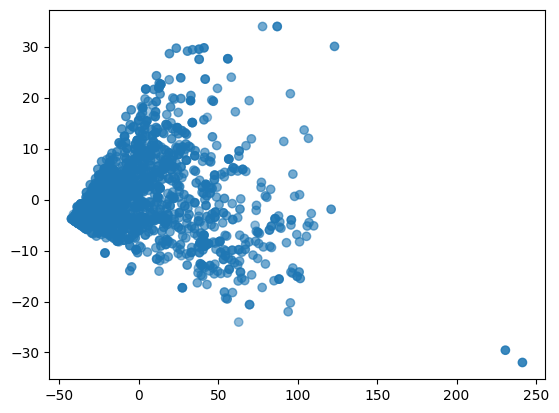

In [66]:
plt.scatter(pca.transform(X)[:, 0], pca.transform(X)[:, 1], alpha=y/np.max(y))